# Import Libraries

In [41]:
# !pip install --quiet --upgrade tensorflow-federated
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [42]:
import matplotlib.pyplot as plt


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff



SEED = 0
tf.random.set_seed(SEED)
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [44]:
from tensorflow import keras
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras import layers

from sklearn.model_selection import GroupShuffleSplit

# Load Data


In [45]:
path = "/content/drive/MyDrive/Thesis/Datasets/Turbofan_Dataset/final_datasets_normalized/"

In [46]:
# Load data and drop irrelevant columns

alice_set = pd.read_csv(path + "TRAINING_SET_1.csv")
bob_set = pd.read_csv(path + "TRAINING_SET_2.csv")

test_set = pd.read_csv(path + "TEST_SET_FULL.csv")


drop_cols = ["cycle","setting3","s1","s5","s10","s16","s18","s19","RUL"]
corr_cols = ["s11","s4","s15","s17","s2","s3","s8","s13","s9","s14","s12","s7","s20"]
feature_cols = ['cycle_norm', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
prediction_col = 'fail_30'

alice_set = alice_set.drop(drop_cols, axis=1)
bob_set = bob_set.drop(drop_cols, axis=1)

test_set = test_set.drop(drop_cols, axis=1)

In [47]:
# Move cycle_norm column first for convenience

column_to_move = alice_set.pop("cycle_norm")
alice_set.insert(0, "cycle_norm", column_to_move)
column_to_move = bob_set.pop("cycle_norm")
bob_set.insert(0, "cycle_norm", column_to_move)

column_to_move = test_set.pop("cycle_norm")
test_set.insert(0, "cycle_norm", column_to_move)

In [48]:
alice_set.shape

(9909, 20)

In [49]:
bob_set.shape

(10722, 20)

In [50]:
test_set.shape

(13096, 20)

# Sequence Generation

In [51]:
# Receives single engine dataframe, window size and features -> sequences of length==window_size
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [52]:
# Generates sequences for multiple engines
def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    data_gen = (list(gen_train_data(df[df['id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [53]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [54]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]
def gen_test_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
    
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    # keep only last window
    if sequence_length > 31:
      print("Too big window")
    else:
      last_labels = [label[-1] for label in label_gen] 
      



    last_labels = np.concatenate(last_labels).astype(np.float32)
    # return label_array
    return last_labels


In [55]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
        
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [56]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]
def gen_test_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['id'].unique()
    
    label_gen = [gen_labels(df[df['id']==id], sequence_length, label) 
                for id in ids]
    # keep only last window
    if sequence_length > 31:
      print("Too big window")
    else:
      last_labels = [label[-1] for label in label_gen] 
      
    last_labels = np.concatenate(last_labels).astype(np.float32)
    # return label_array
    return last_labels


In [57]:
sequence_length = 20

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)


for alice_train_unit, alice_val_unit in gss.split(alice_set['id'].unique(), groups=alice_set['id'].unique()):
    alice_train_unit = alice_set['id'].unique()[alice_train_unit]  # gss returns indexes and index starts at 1
    alice_val_unit = alice_set['id'].unique()[alice_val_unit]

    train_split_array = gen_data_wrapper(alice_set, sequence_length, feature_cols, alice_train_unit)
    train_split_label = gen_label_wrapper(alice_set, sequence_length, ['fail_30'], alice_train_unit)
    
    val_split_array = gen_data_wrapper(alice_set, sequence_length, feature_cols, alice_val_unit)
    val_split_label = gen_label_wrapper(alice_set, sequence_length, ['fail_30'], alice_val_unit)

for bob_train_unit, bob_val_unit in gss.split(bob_set['id'].unique(), groups=bob_set['id'].unique()):
    bob_train_unit = bob_set['id'].unique()[bob_train_unit]  # gss returns indexes and index starts at 1
    bob_val_unit = bob_set['id'].unique()[bob_val_unit]

    train_split_array = gen_data_wrapper(bob_set, sequence_length, feature_cols, bob_train_unit)
    train_split_label = gen_label_wrapper(bob_set, sequence_length, ['fail_30'], bob_train_unit)
    
    val_split_array = gen_data_wrapper(bob_set, sequence_length, feature_cols, bob_val_unit)
    val_split_label = gen_label_wrapper(bob_set, sequence_length, ['fail_30'], bob_val_unit)

# create sequences train, test 
X_alice = gen_data_wrapper(alice_set, sequence_length, feature_cols)
X_bob = gen_data_wrapper(bob_set, sequence_length, feature_cols)

y_alice = gen_label_wrapper(alice_set, sequence_length, ['fail_30'])
y_bob = gen_label_wrapper(bob_set, sequence_length, ['fail_30'])

X_test = gen_data_wrapper(test_set, sequence_length, feature_cols)
y_test = gen_label_wrapper(test_set, sequence_length, ['fail_30'])


# test_gen = (list(gen_test_data(test_set[test_set['id']==id], sequence_length, feature_cols, -99.))
#            for id in test_set['id'].unique())
# X_test = np.concatenate(list(test_gen)).astype(np.float32)

# y_test = gen_test_label_wrapper(test_set, sequence_length, ['fail_30'])


In [82]:
X_alice.shape

(8959, 20, 18)

In [59]:
# train/validation 80/20 split

In [60]:
X_bob.shape

(9772, 20, 18)

# Hyperparameters

In [61]:
# BATCH_SIZE = 16
# GLOBAL_EPOCHS = 10
# LOCAL_EPOCHS = 25

BATCH_SIZE = 32
GLOBAL_EPOCHS = 10
LOCAL_EPOCHS = 5

# Federated Dataset

In [62]:
alice_split = round(X_alice.shape[0] * 0.8)

In [63]:
bob_split = round(X_bob.shape[0] * 0.8)

In [64]:
# y_alice = y_alice.astype(np.int32)
# y_bob = y_bob.astype(np.int32)

In [65]:
X_alice[:bob_split].shape

(7818, 20, 18)

In [66]:
np.concatenate([X_alice[alice_split:],X_bob[bob_split:]]).shape

(3746, 20, 18)

In [67]:
np.concatenate([y_alice[alice_split:],y_bob[bob_split:]]).shape

(3746, 1)

In [68]:
train_data, test_data, val_data = [], [], []

temp_dataset = tf.data.Dataset.from_tensor_slices((X_alice[:alice_split], y_alice[:alice_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)
temp_dataset = tf.data.Dataset.from_tensor_slices((X_bob[:bob_split], y_bob[:bob_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)


temp_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data.append(temp_dataset.batch(1))

X_val = np.concatenate([X_alice[alice_split:],X_bob[bob_split:]])
y_val = np.concatenate([y_alice[alice_split:],y_bob[bob_split:]])

temp_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data.append(temp_dataset.batch(BATCH_SIZE))


In [69]:
test_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>]

In [70]:
val_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>]

# Create Model

In [71]:
def input_spec():
    return (
        tf.TensorSpec([None, 20, 18], tf.float32),
        tf.TensorSpec([None, 1], tf.float32)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(20, 18)),                                       
        tf.keras.layers.LSTM(32, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), Precision(), Recall()])

# Training

In [72]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [73]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    # server_optimizer_fn=lambda: tf.keras.optimizers.SGD( learning_rate=0.1)
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate= 0.1)

)

state = trainer.initialize()
train_hist = []
losses = []
accs = []

val_losses = []
val_accs = []
for i in range(GLOBAL_EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)
    losses.append(metrics['train']['loss'])
    accs.append(metrics['train']['binary_accuracy'])

    val_metrics = evaluator(state.model, val_data)
    val_losses.append(val_metrics['eval']['loss'])
    val_accs.append(val_metrics['eval']['binary_accuracy'])

    print(f"\rRun {i+1}/{GLOBAL_EPOCHS} _ loss={metrics['train']['loss']} _ acc={metrics['train']['binary_accuracy']}")

Run 1/10 _ loss=0.19812917709350586 _ acc=0.9232298731803894
Run 2/10 _ loss=0.13841262459754944 _ acc=0.9437837600708008
Run 3/10 _ loss=0.11865349858999252 _ acc=0.9500834345817566
Run 4/10 _ loss=0.10426780581474304 _ acc=0.9579846262931824
Run 5/10 _ loss=0.0897069200873375 _ acc=0.9644444584846497
Run 6/10 _ loss=0.07673049718141556 _ acc=0.9676209688186646
Run 7/10 _ loss=0.0732833594083786 _ acc=0.9685018062591553
Run 8/10 _ loss=0.07038406282663345 _ acc=0.9702903032302856
Run 9/10 _ loss=0.06522784382104874 _ acc=0.9727727770805359
Run 10/10 _ loss=0.06322711706161499 _ acc=0.9739205837249756


In [74]:
train_metrics = evaluator(state.model, train_data)
train_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9746413),
                           ('precision', 0.9362664),
                           ('recall', 0.91007197),
                           ('loss', 0.06392396),
                           ('num_examples', 74925),
                           ('num_batches', 2342)]))])

In [75]:
train_metrics['eval']

OrderedDict([('binary_accuracy', 0.9746413),
             ('precision', 0.9362664),
             ('recall', 0.91007197),
             ('loss', 0.06392396),
             ('num_examples', 74925),
             ('num_batches', 2342)])

In [76]:
test_metrics = evaluator(state.model, test_data)
test_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.98972845),
                           ('precision', 0.8401254),
                           ('recall', 0.8072289),
                           ('loss', 0.02676508),
                           ('num_examples', 11196),
                           ('num_batches', 11196)]))])

In [77]:
def plot(train, valid, name):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(train)+1), train, label='train')
    plt.plot(range(1, len(valid)+1), valid, label='validate')
    plt.xlabel('Rounds')
    plt.ylabel(name)
    plt.legend()
    plt.show()

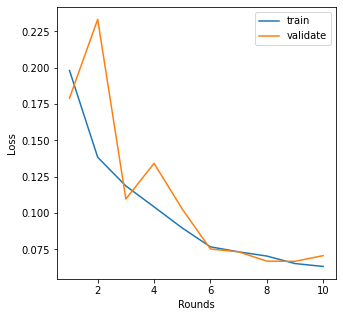

In [78]:
plot(losses, val_losses, 'Loss')

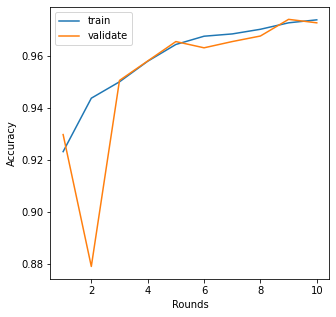

In [79]:
plot(accs, val_accs, 'Accuracy')

In [80]:
type(state.model)

tensorflow_federated.python.learning.model_utils.ModelWeights